In [1]:
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
from matplotlib import pyplot as plt
from collections import Counter
from tqdm.auto import tqdm

2024-06-09 09:42:00.029772: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv("train.csv", header=None)
display(data)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.1,e-399,NaN,w-219,NaN,NaN,w-77,w-71,w-72,w-109,...,w-196,w-185,NaN,NaN,NaN,w-215,1,0,0,0
1,0.3,e-399,NaN,w-219,NaN,NaN,w-77,w-71,w-72,w-109,...,w-196,w-185,NaN,NaN,NaN,w-215,1,0,0,0
2,0.6,e-397,NaN,w-215,NaN,NaN,w-77,w-73,w-72,w-109,...,w-197,w-185,NaN,NaN,NaN,w-213,1,0,0,0
3,0.8,e-396,NaN,w-214,NaN,NaN,w-79,w-72,w-72,w-109,...,w-196,w-185,NaN,NaN,NaN,w-213,1,0,0,0
4,1.0,e-394,NaN,w-211,NaN,NaN,w-81,w-70,w-72,w-109,...,w-196,w-185,NaN,NaN,NaN,w-211,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12163,-4.3,w-185,d-322,w-127,w-130,w-187,NaN,NaN,NaN,e-153,...,w-28,w-30,w-35,w-44,w-43,w-73,0,1,1,0
12164,-4.4,w-187,d-327,w-133,w-134,w-189,NaN,NaN,NaN,e-150,...,w-28,w-30,w-32,w-41,w-47,w-64,0,1,1,0
12165,-4.5,w-136,d-331,w-144,w-137,w-191,NaN,NaN,NaN,e-148,...,w-31,w-29,w-33,w-40,w-51,w-56,0,1,1,0
12166,-4.6,w-96,d-336,w-152,w-137,w-193,NaN,NaN,NaN,e-145,...,w-35,w-32,w-31,w-37,w-53,w-59,0,1,1,0


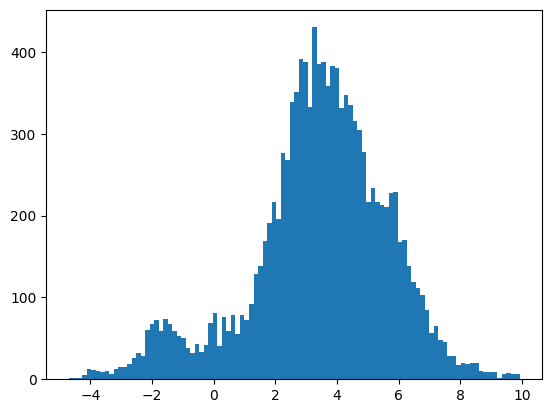

In [3]:
plt.hist(data[0], bins=100)
plt.show()

In [4]:
Counter(tuple(row[1]) for row in data[[25,26,27,28]].iterrows())

Counter({(1, 0, 0, 0): 1826,
         (1, 0, 1, 0): 869,
         (0, 0, 1, 0): 2871,
         (0, 0, 0, 0): 2585,
         (0, 1, 0, 0): 353,
         (0, 0, 0, 1): 2689,
         (1, 0, 0, 1): 651,
         (0, 1, 1, 0): 196,
         (0, 1, 0, 1): 127,
         (0, 0, 1, 1): 1})

In [5]:
def parse_sensor(s, letters, max_val=501.0):
    if not s:
        return 1.0
    if s[0] not in letters:
        return 1.0
    return float(s[2:])/max_val
    

X = []
Y = []
with open("train.csv") as f:
    for row in tqdm(csv.reader(f)):
        velocity = np.array([float(row[0])])
        sensors = row[1:25]
        keys = np.fromiter((float(k) for k in row[25:]), dtype=float)
        walls = np.fromiter((parse_sensor(s, ("w", "e")) for s in sensors), dtype=float)
        diamants = np.fromiter((parse_sensor(s, ("d")) for s in sensors), dtype=float)
        X.append(np.concatenate((velocity, walls, diamants)))
        Y.append(keys)

X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

0it [00:00, ?it/s]

((12168, 49), (12168, 4))

In [6]:
def create_ff_model():
    input = tf.keras.Input(shape=(49,), name="input")
    hidden = tf.keras.layers.Dense(64, activation="tanh", name="hidden1")(input)
    output = tf.keras.layers.Dense(4, activation='sigmoid', name='output')(hidden)

    model = tf.keras.Model(name="ff_model", inputs=input, outputs=output)
    model.compile(optimizer='adam', loss="binary_crossentropy")
    return model

ff_model = create_ff_model()

In [7]:
ff_model.summary()

Model: "ff_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 64)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,460 (13.52 KB)

 Trainable params: 3,460 (13.52 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
ff_model.fit(X, Y, epochs=100, validation_split=0.2)

Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5012 - val_loss: 0.4391
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 0.4077 - val_loss: 0.4253
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.3971 - val_loss: 0.4236
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.3875 - val_loss: 0.4163
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.3836 - val_loss: 0.4124
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.3767 - val_loss: 0.4150
Epoch 7/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 0.3790 - val_loss: 0.4077
Epoch 8/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.3709 - val_loss: 0.4058
Epoch 9/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 0.3673 - val_loss: 0.4116
Epoch 10/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.3664 - val_loss: 0.4077
Epoch 11/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.3668 - val_loss: 0.4007
Epoch 12/100
305/305 

In [9]:
ff_model.export("../models/ff")

INFO:tensorflow:Assets written to: ../models/ff/assets


INFO:tensorflow:Assets written to: ../models/ff/assets


Saved artifact at '../models/ff'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 49), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  128822254049184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128822214592640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128822214592464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128822214591408: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [10]:
import random
random.seed(42)

test_input = np.array([[random.random() for _ in range(49)]])

In [11]:
ff_model(test_input)[0].numpy()

array([2.3518853e-04, 3.6624519e-03, 1.3104123e-02, 8.9012289e-01],
      dtype=float32)

In [12]:
!python -m tf2onnx.convert --saved-model ../models/ff --output ../models/ff.onnx --opset 13

2024-06-09 09:42:31.179162: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2024-06-09 09:42:33,328 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2024-06-09 09:42:33,329 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2024-06-09 09:42:33,465 - INFO - Signatures found in model: [serve,serving_default].
2024-06-09 09:42:33,465 - WARNING - '--signature_def' not specified, using first signature: serve
2024-06-09 09:42:33,465 - IN

In [13]:
import onnxruntime

In [14]:
onnx_session = onnxruntime.InferenceSession("../models/ff.onnx")

In [15]:
onnx_session.run(["output_0"], {"input": test_input.astype(np.float32)})[0][0]

array([2.3519993e-04, 3.6624670e-03, 1.3104141e-02, 8.9012289e-01],
      dtype=float32)

In [16]:
sigmoid = lambda x: 1/(1 + np.exp(-x)) 

In [17]:
def create_numpy_model(tf_model):
    weights = [w.numpy().astype(np.float32) for w in tf_model.weights]

    def numpy_model(input):
        hidden = np.tanh(np.matmul(input, weights[0]) + weights[1])
        output = sigmoid(np.matmul(hidden, weights[2]) + weights[3])
        return output

    return numpy_model

In [18]:
ff_model_np = create_numpy_model(ff_model)

In [19]:
ff_model_np(test_input.astype(np.float32))

array([[2.3518830e-04, 3.6624726e-03, 1.3104123e-02, 8.9012289e-01]],
      dtype=float32)